In [1]:
import os
import pickle
#import rpy2.robjects as robjects
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import scipy.sparse as sp
from torchvision import transforms as tfs
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from torch_geometric.nn import HGTConv, Linear
#from torch_geometric.loader import HGTLoader
from torch.cuda.amp import autocast
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score
from torchsummary import summary
import random
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from torch.utils.data import WeightedRandomSampler
import math
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(2022)

from torch.nn.parameter import Parameter

class eca_layer(nn.Module):
    """Constructs a ECA module.
    Args:
        channel: Number of channels of the input feature map
        k_size: Adaptive selection of kernel size
    """
    def __init__(self, channel, k_size=3):
        super(eca_layer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # feature descriptor on the global spatial information
        #print(x.size())
        y = self.avg_pool(x)
        #print(y.size())
        # Two different branches of ECA module
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)
        #print(y.size())
        # Multi-scale information fusion
        y = self.sigmoid(y)
        #print(y.size())
        out=x * y.expand_as(x)
        #print(out.size())
        return out


def default(val, d):
    return val if exists(val) else d

def exists(val):
    return val is not None

def conv_kx1(in_channels, out_channels, kernel_size, stride=1):
    layers = []
    padding = kernel_size - 1
    padding_left = padding // 2
    padding_right = padding - padding_left
    layers.append(nn.ConstantPad1d((padding_left, padding_right), 0))
    layers.append(nn.Conv1d(in_channels, out_channels, kernel_size, stride))
    return nn.Sequential(*layers)

def conv_kx2(in_channels, out_channels, kernel_size, stride=1):
    layers = []
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride))
    return nn.Sequential(*layers)

class Conv2_Layer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(Conv2_Layer, self).__init__()
        #self.relu = nn.ReLU()
        #self.eca1=eca_layer(in_channels,3)
        self.conv1 = conv_kx2(in_channels, out_channels[0], kernel_size)
        self.norm1=nn.BatchNorm2d(out_channels[0])
        self.eca2=eca_layer(out_channels[0],3)
        self.conv2 = conv_kx2(out_channels[0], out_channels[1], kernel_size)
        self.norm2=nn.BatchNorm2d(out_channels[1])
        self.eca3=eca_layer(out_channels[1],3)
        self.relu=nn.GELU()
    def forward(self, x):
        #out = self.eca1(x)
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.eca2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.eca3(out)
        out = self.relu(out)
        return out

def ConvBlock(dim, dim_out = None, kernel_size = 1):
    return nn.Sequential(
        nn.BatchNorm1d(dim),
        nn.GELU(),
        conv_kx1(dim, default(dim_out, dim), kernel_size))

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout = 0.3, max_len=35526):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) * (-(math.log(10000.0) / d_model)))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)],requires_grad=False)
        return self.dropout(x)

class gCNN(nn.Module):
    def __init__(self,max_len=2500,dim=128,nhead=4,num_layers=2,pool_size=[(3,1),3,11],out_channels=[7,1],stem_kernel_size=[(7,1),7],dropout_rate=0.3):
        super(gCNN, self).__init__()
        self.stem1 = nn.Sequential(
            Conv2_Layer(15,out_channels,stem_kernel_size[0]),
            nn.MaxPool2d(pool_size[0])
        )
        out_length = np.floor((((max_len-(stem_kernel_size[0][0]*2)+2) - pool_size[0][0]) / pool_size[0][0]) + 1)
        print(out_length)
        self.stem2 = nn.Sequential(
            conv_kx1(4, dim, stem_kernel_size[1]),
            Residual(ConvBlock(dim,dim,stem_kernel_size[1])),
            nn.MaxPool1d(pool_size[1])
        )
        out_length = np.floor(((out_length - pool_size[1]) / pool_size[1]) + 1)
        print(out_length)
        self.stem3 = nn.Sequential(
            #conv_kx1(64, dim, stem_kernel_size[1]),
            Residual(ConvBlock(dim,dim,stem_kernel_size[1])),
            nn.MaxPool1d(pool_size[2])
        )
        out_length = np.floor(((out_length - pool_size[2]) / pool_size[2]) + 1)
        print(out_length)
        self.position = PositionalEncoding(d_model=dim,max_len=int(out_length))
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=nhead,batch_first=True,dim_feedforward=256,activation='gelu',dropout=dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # self.linear = nn.Linear(int(dim * out_length), 1024)
        # self.relu = nn.GELU()
        # self.dropout = nn.Dropout(p=dropout_rate if dropout_rate is not None else 0)
    def forward(self, x):
        #print(x.size())
        x = self.stem1(x)
        #print(x.size())
        x=x.view(x.size()[0],x.size()[2],x.size()[3])
        #print(x.size())
        x=x.permute(0,2,1)
        #print(x.size())
        x=self.stem2(x)
        #print(x.size())
        x=self.stem3(x)
        #print(x.size())
        x=x.permute(0, 2, 1)
        #print(x.size())
        x = self.position(x)
        #print(x.size())
        x = self.transformer_encoder(x)
        #print(x.size())
        x = x.reshape(len(x), -1)
        #print(x.size())
        # x = self.linear(x)
        # x = self.relu(x)
        # x = self.dropout(x)
        #print(x.size())
        return x

class mCNN(nn.Module):
    def __init__(self,max_len=25,dim=128,nhead=8,num_layers=2,stem_kernel_size=7,dropout_rate=0.3):
        super(mCNN, self).__init__()
        self.stem = nn.Sequential(
            #nn.Conv1d(4, dim, 7),
            conv_kx1(4, dim, stem_kernel_size),
            Residual(ConvBlock(dim,dim,stem_kernel_size))
            #AttentionPool(dim, pool_size = 2)
        )
        self.position = PositionalEncoding(d_model=dim,max_len=max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=nhead,batch_first=True,dim_feedforward=256,activation='gelu',dropout=dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # self.linear = nn.Linear(int(dim * max_len), 1024)
        # self.relu = nn.GELU()
        # self.dropout = nn.Dropout(p=dropout_rate if dropout_rate is not None else 0)
    def forward(self, x):
        #print(x.size())
        x=x.permute(0, 2, 1)
        #print(x.size())
        x = self.stem(x)
        #print(x.size())
        #x = self.conv_tower(x)
        #print(x.size())
        x=x.permute(0, 2, 1)
        #print(x.size())
        x = self.position(x)
        #print(x.size())
        x = self.transformer_encoder(x)
        #print(x.size())
        x = x.reshape(len(x), -1)
        #print(x.size())
        # x = self.linear(x)
        # x = self.relu(x)
        # x = self.dropout(x)
        #print(x.size())
        return x

class MLPBilPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, dropout_rate=0.3):
        super(MLPBilPredictor, self).__init__()
        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(in_channels, hidden_channels[0]))
        for i in range(num_layers - 1):
            self.lins.append(torch.nn.Linear(hidden_channels[i], hidden_channels[i+1]))
        self.bilin = torch.nn.Linear(hidden_channels[-1], hidden_channels[-1], bias=False)
        self.dropout = nn.Dropout(p=dropout_rate if dropout_rate is not None else 0)
        # self.bilin = torch.nn.Linear(in_channels,in_channels, bias=False)
        self.relu = nn.GELU()

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()
        self.bilin.reset_parameters()

    def forward(self, x_i, x_j):
        for lin in self.lins:
            x_i, x_j = lin(x_i), lin(x_j)
            x_i, x_j = self.dropout(self.relu(x_i)), self.dropout(self.relu(x_j))
        x = torch.sum(self.bilin(x_i) * x_j, dim=-1)
        # x1 = torch.sum(self.bilin(x_i) * x_j, dim=-1)
        # x2 = torch.sum(self.bilin(x_j) * x_i, dim=-1)
        # x = x1+x2
        # x = torch.sum(x_i * x_j, dim=-1)
        return x,x_i,x_j

# class MLPBilPredictor(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, num_layers, dropout_rate=0.3):
#         super(MLPBilPredictor, self).__init__()
#         self.lins = torch.nn.ModuleList()
#         self.lins.append(torch.nn.Linear(in_channels, hidden_channels[0]))
#         for i in range(num_layers - 1):
#             self.lins.append(torch.nn.Linear(hidden_channels[i], hidden_channels[i+1]))
#         # self.bilin = torch.nn.Linear(hidden_channels, hidden_channels, bias=False)
#         # self.bilin = torch.nn.Linear(in_channels,in_channels, bias=False)
#         self.pre = torch.nn.Linear(hidden_channels[-1],1)
#         self.relu = nn.GELU()
#         self.dropout = nn.Dropout(p=dropout_rate if dropout_rate is not None else 0)
#
#     def reset_parameters(self):
#         for lin in self.lins:
#             lin.reset_parameters()
#         self.lin.reset_parameters()
#
#     def forward(self, x):
#         for lin in self.lins:
#             x= lin(x)
#             x= self.dropout(self.relu(x))
#         x = self.pre(x)
#         # x1 = torch.sum(self.bilin(x_i) * x_j, dim=-1)
#         # x2 = torch.sum(self.bilin(x_j) * x_i, dim=-1)
#         # x = x1+x2
#         # x = torch.sum(x_i * x_j, dim=-1)
#         return x

class CNNmt(torch.nn.Module):
    def __init__(self,max_len=[25,2500],dim=[128,128],nhead=[4,4],num_layers=[2,2],pool_size=[(3,1),3,11],out_channels=[7,1],stem_kernel_size=[(7,1),7],dropout_rate=0.3):
        #max_len=25,dim=128,nhead=8,num_layers=2
        super(CNNmt, self).__init__()
        self.mcnn = mCNN(max_len[0],dim[0],nhead[0],num_layers[0],stem_kernel_size[1],dropout_rate)
        self.gcnn = gCNN(max_len[1],dim[1],nhead[1],num_layers[1],pool_size,out_channels,stem_kernel_size,dropout_rate)
        # self.linear = nn.Linear(3200, 1024)
        # self.relu = nn.GELU()
        # self.dropout = nn.Dropout(p=dropout_rate if dropout_rate is not None else 0)
        self.predict=MLPBilPredictor(3200, [1024], 1)
        # self.lin1 = Linear(1024*2, 1024)
        # self.lin2 = Linear(1024,128)
        # self.lin = Linear(128,1)
        # #self.relu = nn.LeakyReLU()
        # self.relu = nn.GELU()
        # #self.sig=nn.Sigmoid()
        # self.dropout = nn.Dropout(p=dropout_rate if dropout_rate is not None else 0)
    def encoder(self, xm, xg):
        xm=self.mcnn(xm)
        xg=self.gcnn(xg)
        # xm = self.linear(xm)
        # xm = self.relu(xm)
        # xm = self.dropout(xm)
        # xg = self.linear(xg)
        # xg = self.relu(xg)
        # xg = self.dropout(xg)
        return xm,xg
    def decoder(self, xm, xg):
        #x=torch.cat([xm, xg], dim=1)
        s,xm,xg=self.predict(xm, xg)
        # x=self.lin1(x)
        # x = self.relu(x)dgg
        # x = self.dropout(x)
        # x=self.lin2(x)
        # x = self.relu(x)
        # s=self.lin(x)
        return s,xm,xg
    def forward(self, xm, xg):
        xm,xg=self.encoder(xm,xg)
        s,xm,xg=self.decoder(xm,xg)
        return s,xm,xg

def trainEpoch(model,trainloader,scaler,lossF):
    model.train()
    trainloss=0
    auc=0
    aupr=0
    #acc=0
    for step,dat in enumerate(trainloader):
        xm,xg,mid,gid,rel=dat
        xm,xg,mid,gid,rel=xm.to(device),xg.to(device),mid.to(device),gid.to(device),rel.to(device)
        optimizer.zero_grad()
        # 训练模型
        #with autocast():
        #out = model(dat.x_dict,dat.seq_dict, dat.edge_index_dict)
        out,_,_ = model(xm, xg)
        out=out.view(-1)
        #pre=out[mid,gid]
        #print(rel)
        #loss = F.binary_cross_entropy_with_logits(out,rel)
        loss=lossF(out,rel)
        #metric=model_evaluation(pre,rel.int())
        #print(out)
        pre=torch.sigmoid(out)
        #print(pre)
        #assert torch.isnan(loss).sum() == 0, print(loss)
        metric0=roc_auc_score(rel.cpu().detach().numpy(), pre.cpu().detach().numpy())
        metric1= average_precision_score(rel.cpu().detach().numpy(), pre.cpu().detach().numpy())
        #         scaler.scale(loss).backward()
        #         scaler.step(optimizer)  # optimizer.step
        #         scaler.update()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        trainloss = trainloss+loss.item()
        #acc=acc+metric['accuracy']
        auc=auc+metric0
        aupr=aupr+metric1
        if (step % 100 == 0):
            train_loss = (trainloss / (step+1))
            auc_batch = (auc / (step+1))
            aupr_batch = (aupr / (step+1))
            #train_loss.append(trainloss)
            print('Batch:',step,train_loss,auc_batch,aupr_batch)
    return (trainloss/(step+1),auc/(step+1),aupr/(step+1))

def evaluate(model,valloader,lossF):
    model.eval()
    valloss=0
    valauc=0
    valaupr=0
    with torch.no_grad():
        for step,dat in enumerate(valloader):
            xm,xg,mid,gid,rel=dat
            xm,xg,mid,gid,rel=xm.to(device),xg.to(device),mid.to(device),gid.to(device),rel.to(device)
            #pre=out[mid,gid]
            out,_,_ = model(xm, xg)
            out=out.view(-1)
            #loss = F.binary_cross_entropy_with_logits(out,rel)
            loss=lossF(out,rel)
            #metric=model_evaluation(pre,rel.int())
            #print(rel,pre)
            pre=torch.sigmoid(out)
            auc=roc_auc_score(rel.cpu(), pre.cpu())
            aupr= average_precision_score(rel.cpu(), pre.cpu())
            valloss = valloss+loss.item()
            valauc=valauc+auc
            valaupr=valaupr+aupr
            if (step % 100 == 0):
                val_loss = (valloss / (step+1))
                #val_loss.append(valloss)
                val_auc=(valauc/(step+1))
                val_aupr=(valaupr/(step+1))
                print('Batch:',step,val_loss,val_auc,val_aupr)
    return (valloss/(step+1)),(valauc/(step+1)),(valaupr/(step+1))

class seqData(Dataset):
    def __init__(self,xm,xg,label,edgeidx):
        self.source= xm
        self.target=xg
        self.edge=edgeidx
        self.label = label
        self.length = len(self.label)
    def __getitem__(self, index):
        s=self.edge[0][index]
        t=self.edge[1][index]
        return self.source[s], self.target[t],s,t,self.label[index]
    def __len__(self):
        return self.length

class FocalLoss(nn.Module):
    def __init__(self,alpha=0.25,gamma=2.0,reduce='mean'):
        super(FocalLoss,self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self,classifications,targets):
        # classifcation:[N,K]
        # targets: [N,K]的one-hot编码
        alpha = self.alpha
        gamma = self.gamma
        # classifications = classifications.view(-1)  # 不经过sigmoid的classification；
        # targets = targets.view(-1)                  # 应该是 one-hot
        # ce_loss: 对应公式中 -log(pt),也就是普通的 交叉熵损失；--> 该函数接收未经sigmoid的函数；
        ce_loss = F.binary_cross_entropy_with_logits(classifications, targets, reduction="none")
        #focal loss
        p = torch.sigmoid(classifications)                # 经过sigmoid
        p_t = p * targets + (1 - p) * (1 - targets)       #  计算pt
        loss = ce_loss * ((1 - p_t) ** gamma)             # -log(pt) * (1-pt) ** ganmma
        if alpha >= 0:
            # 对应公式中alpha_t控制损失的权重
            alpha_t = alpha * targets + (1 - alpha) * (1 - targets) # 和pt求解过程一样
            loss = alpha_t * loss                         # 最终focal loss
        if self.reduce=='sum':
            loss = loss.sum()
        elif self.reduce=='mean':
            loss = loss.mean()
        else:
            raise ValueError('reduce type is wrong!')
        return loss

class BCEFocalLoss(torch.nn.Module):
    def __init__(self, gamma=2, alpha=0.25, reduction='elementwise_mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, _input, target):
        pt = torch.sigmoid(_input)
        loss = - self.alpha * (1 - pt) ** self.gamma * target * torch.log(pt) - \
               (1-self.alpha)*pt ** self.gamma * (1 - target) * torch.log(1 - pt)
        #         loss = - self.alpha * pt ** self.gamma * target * torch.log(pt) - \
        #             (1-self.alpha)*(1 - pt)** self.gamma * (1 - target) * torch.log(1 - pt)
        if self.reduction == 'elementwise_mean':
            loss = torch.mean(loss)
        elif self.reduction == 'sum':
            loss = torch.sum(loss)
        return loss

# class EarlyStopping():
#     def __init__(self, tolerance=5, min_delta=0.1):
#         self.tolerance = tolerance
#         self.min_delta = min_delta
#         self.counter = 0
#         self.early_stop = False
#     def __call__(self, train_auc, validation_auc):
#         if (train_auc - validation_auc) > self.min_delta:
#             self.counter +=1
#             if self.counter >= self.tolerance:
#                 self.early_stop = True

class EarlyStopping():
    def __init__(self, tolerance=50, min_delta=0.1):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False
    def __call__(self, val_best_auc, val_auc):
        if val_auc<val_best_auc:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

# if __name__ == '__main__':
#     with open('/lustre06/project/6050659/liupei89/Testcell/newNetData/pos_neg/newdataSplit00_newall.pkl','rb') as f:  # Python 3: open(..., 'rb')
#         Xm,Xg,nodeM,nodeG,trainidx,validx,testidx,trainId,trainLabel,testId,testLabel,valId,valLabel,ppi,m,g = pickle.load(f)

#     train_data=seqData(Xm,Xg,trainLabel,trainId)
#     test_data=seqData(Xm,Xg,testLabel,testId)
#     val_data=seqData(Xm,Xg,valLabel,valId)

#     train_loader = DataLoader(dataset=train_data, batch_size=256, shuffle=True)
#     val_loader = DataLoader(dataset=val_data, batch_size=256, shuffle=True)
#     test_loader = DataLoader(dataset=test_data, batch_size=256, shuffle=True)

#     model = CNNmt(max_len=[25,2500],dim=[128,128],nhead=[8,8],num_layers=[1,1],pool_size=[(3,1),3,11],out_channels=[7,1],stem_kernel_size=[(7,1),3],dropout_rate=0.3)
#     print(model)

#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model.to(device)

#     for m in model.modules():
#         if isinstance(m, (torch.nn.Linear, torch.nn.Conv1d, torch.nn.Conv2d)):
#             torch.nn.init.kaiming_normal_(m.weight, mode = 'fan_in')

#     optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=5e-3)#
#     #optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
#     scaler = torch.cuda.amp.GradScaler(enabled=True)
#     #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 50, eta_min=1e-5)
#     #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", 0.1, 5)
#     #lossF=nn.BCEWithLogitsLoss()
#     #lossF=BCEFocalLoss(gamma=2, alpha=0.35, reduction='elementwise_mean')
#     lossF=FocalLoss(alpha=0.65, gamma=2,reduce='mean')
#     early_stopping = EarlyStopping(tolerance=200, min_delta=0.15)


#     import time
#     best_val_auc= best_val_aupr= 0
#     trainloss=[]
#     valloss=[]
#     valauc=[]
#     trainauc=[]
#     valaupr=[]
#     trainaupr=[]
#     lrchange=[]
#     for epoch in range(1, 501):
#         since = time.time()
#         print('{} optim: {}'.format(epoch, optimizer.param_groups[0]['lr']))
#         lrchange.append(optimizer.param_groups[0]['lr'])
#         train_loss,train_auc,train_aupr = trainEpoch(model,train_loader,scaler,lossF)
#         trainloss.append(train_loss)
#         print('train_loss:',train_loss)
#         val_loss,val_auc,val_aupr = evaluate(model,val_loader,lossF)
#         valauc.append(val_auc)
#         valloss.append(val_loss)
#         trainauc.append(train_auc)
#         valaupr.append(val_aupr)
#         trainaupr.append(train_aupr)
#         if val_aupr > best_val_aupr:
#             best_val_auc = val_auc
#             best_val_aupr=val_aupr
#             torch.save(model, 'seqCNNbest.pt')
#         #scheduler.step()
#         time_elapsed = time.time() - since
#         log = 'Epoch: {:03d}, Epoch complete in {:.0f}m {:.0f}s, trainLoss: {:.4f}, Valloss: {:.4f}, Trainauc: {:.4f}, Valauc: {:.4f}, Valbestauc: {:.4f},Trainaupr: {:.4f}, Valaupr: {:.4f}, Valbestaupr: {:.4f}'
#         print(log.format(epoch, time_elapsed // 60, time_elapsed % 60,train_loss, val_loss,train_auc,val_auc,best_val_auc,train_aupr,val_aupr,best_val_aupr))

#         # early_stopping(best_val_auc, val_auc)
#         # if early_stopping.early_stop:
#         #     print("We are at epoch:", epoch)
#         #     break

#     with open('modelResult.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#         pickle.dump([trainloss, trainauc,trainaupr,valloss,valauc,valaupr,lrchange], f)

#     torch.save(model, 'seqCNN.pt')

In [2]:
##data 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CNN = torch.load("/home/liupei89/shfolder/new/TransCNN/13/seqCNNbest.pt")
#/home/liupei89/shfolder/new/TransCNN/3/data10_0.35_0.0001_earlystop
#/home/liupei89/shfolder/new/TransCNN/3/data10_0.35_0.0001_500
#/home/liupei89/shfolder/new/TransCNN/4/data10_0.25_500
#CNN.to(device)
CNN.cpu()

CNNmt(
  (mcnn): mCNN(
    (stem): Sequential(
      (0): Sequential(
        (0): ConstantPad1d(padding=(1, 1), value=0)
        (1): Conv1d(4, 128, kernel_size=(3,), stride=(1,))
      )
      (1): Residual(
        (fn): Sequential(
          (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): GELU()
          (2): Sequential(
            (0): ConstantPad1d(padding=(1, 1), value=0)
            (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
          )
        )
      )
    )
    (position): PositionalEncoding(
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=256, bias=True)
          (dropout): Dropout(

In [3]:
import matplotlib.pyplot as plt

In [4]:
with open('/lustre06/project/6050659/liupei89/Testcell/newNetData/pos_neg/newdataCombine00_newall.pkl','rb') as f:  # Python 3: open(..., 'rb')
        train_data,val_data,test_data,m,g = pickle.load(f)

train_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
val_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
test_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
train_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
val_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
test_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
nodetypes=train_data.node_types
metadata=train_data.metadata()

In [6]:
m=test_data['regulate'].edge_label_index[0]
m

tensor([ 99, 106,  35,  ...,  61, 194, 113])

In [7]:
g=test_data['regulate'].edge_label_index[1]
g

tensor([12183,  5746,  9907,  ...,  4985,  8589, 10503])

In [8]:
xm=test_data['miRNA'].seq[m]

In [9]:
xg=test_data['gene'].seq[g]

In [10]:
xg.size()

torch.Size([8213, 15, 2500, 4])

In [5]:
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [11]:
CNN.eval()
m=test_data['regulate'].edge_label_index[0]
g=test_data['regulate'].edge_label_index[1]
with torch.no_grad():
    xm,xg,rel=test_data['miRNA'].seq[m],test_data['gene'].seq[g],test_data['regulate'].edge_label
    out,m_out,g_out = CNN(xm, xg)
    out=out.view(-1)
    pre=torch.sigmoid(out)
    auc=roc_auc_score(rel.numpy(), pre.numpy())

In [12]:
auc

0.8678388482228215

In [13]:
m_out.size()

torch.Size([8213, 1024])

In [14]:
aupr= average_precision_score(rel.numpy(), pre.numpy())
aupr

0.8072353138210113

In [15]:
pre

tensor([0.0558, 0.9849, 0.1366,  ..., 0.0396, 0.0294, 0.4686])

In [16]:
rel

tensor([1., 1., 1.,  ..., 0., 0., 0.])

In [17]:
print(len(pre),len(rel))

8213 8213


In [22]:
# CNN.eval()
# valloss=0
# valauc=0
# valaupr=0
# allpre=[]
# allrel=[]
# allmid=[]
# allgid=[]
# with torch.no_grad():
#     for step,dat in enumerate(test_loader):
#         xm,xg,mid,gid,rel=dat
#         xm,xg,mid,gid,rel=xm.to(device),xg.to(device),mid.to(device),gid.to(device),rel.to(device)
#         #pre=out[mid,gid]
#         out,m_out,g_out = CNN(xm, xg)
#         out=out.view(-1)
#         #loss = F.binary_cross_entropy_with_logits(out,rel)
#         #loss=lossF(out,rel)
#         #metric=model_evaluation(pre,rel.int())
#         #print(rel,pre)
#         pre=torch.sigmoid(out)
#         allpre.append(pre)
#         allrel.append(rel)
#         allmid.append(mid)
#         allgid.append(gid)
#         auc=roc_auc_score(rel.cpu(), pre.cpu())
#         aupr= average_precision_score(rel.cpu(), pre.cpu())
        
#         #valloss = valloss+loss.item()
#         valauc=valauc+auc
#         valaupr=valaupr+aupr
#         if (step % 100 == 0):
#             #val_loss = (valloss / (step+1))
#             #val_loss.append(valloss)
#             val_auc=(valauc/(step+1))
#             val_aupr=(valaupr/(step+1))
#             print('Batch:',step,val_auc,val_aupr)

In [23]:
# valauc/(step+1)#0.8954 0.97518

In [24]:
# valaupr/(step+1)#0.7614 0.90692

In [9]:
# pre=allpre[0]
# rel=allrel[0]
# mid=allmid[0]
# gid=allgid[0]
# for i in range(1,len(allpre)):
#     pre=torch.cat([pre,allpre[i]])
#     rel=torch.cat([rel,allrel[i]])
#     mid=torch.cat([mid,allmid[i]])
#     gid=torch.cat([gid,allgid[i]])

In [10]:
# pre=pre.cpu()
# rel=rel.cpu()
# mid=mid.cpu()
# gid=gid.cpu()

In [11]:
# edgeindex=torch.stack((mid,gid),dim=0)
# edgeindex.size()

torch.Size([2, 8213])

In [8]:
# rel

tensor([1., 1., 1.,  ..., 0., 0., 0.])

In [18]:
allrelpos=torch.nonzero(rel==1).squeeze()
print(allrelpos.size())
allrelneg=torch.nonzero(rel==0).squeeze()
print(allrelneg.size())

allprepos=torch.nonzero(pre>=0.5).squeeze()##从0开始
print(allprepos.size())
allpreneg=torch.nonzero(pre<0.5).squeeze()##从0开始
print(allpreneg.size())

torch.Size([2223])
torch.Size([5990])
torch.Size([2377])
torch.Size([5836])


In [19]:
a=set(allprepos.numpy())
b=set(allrelpos.numpy())
c=torch.tensor(list(a&b))
tp=c
print(tp.size())#1569

a=set(allprepos.numpy())
b=set(allrelneg.numpy())
c=torch.tensor(list(a&b))
fp=c
print(fp.size())#793

a=set(allpreneg.numpy())
b=set(allrelneg.numpy())
c=torch.tensor(list(a&b))
tn=c
print(tn.size())#5197

a=set(allpreneg.numpy())
b=set(allrelpos.numpy())
c=torch.tensor(list(a&b))
fn=c
print(fn.size())#654

torch.Size([1605])
torch.Size([772])
torch.Size([5218])
torch.Size([618])


In [20]:
recall=tp.size(0)/(tp.size(0)+fn.size(0))
print(recall)

precision=tp.size(0)/(tp.size(0)+fp.size(0))
print(precision)

f1 = 2 * precision * recall / (precision + recall)
print(f1)

0.7219973009446694
0.6752208666386201
0.6978260869565218


In [13]:
with open('TranCNN13_resultcpu_1.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([tp,fp,tn,fn,rel,pre], f)

In [18]:
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [24]:
t=rel
s=pre

In [25]:
t1=t.cpu().numpy()
len(t1)

8213

In [26]:
len(t1[t1==1])#13800 2223

2223

In [27]:
s1=s.cpu().numpy()

In [32]:
# s1=s

In [33]:
# v,index=torch.topk(s1, 2000, largest=True, sorted=True, out=None) 

In [34]:
# t[index]

In [28]:
s1[s1>0.5]=1

In [29]:
s1[s1<=0.5]=0

In [30]:
len(s1[s1==1])#13989 2034

1952

In [31]:
def get_confusion_matrix(trues, preds):
    labels = [0,1]
    conf_matrix = confusion_matrix(trues, preds)
    return conf_matrix

In [32]:
mat=get_confusion_matrix(t1, s1)

In [33]:
mat

array([[5569,  421],
       [ 692, 1531]])

In [34]:
def get_acc_p_r_f1(trues, preds):
    labels = [1]
    TP,FP,FN,TN = 0,0,0,0
    for label in labels:
        preds_tmp = np.array([1 if pred == label else 0 for pred in preds])
        trues_tmp = np.array([1 if true == label else 0 for true in trues])
        # print(preds_tmp, trues_tmp)
        # print()
        # TP预测为1真实为1
        # TN预测为0真实为0
        # FN预测为0真实为1
        # FP预测为1真实为0
        TP += ((preds_tmp == 1) & (trues_tmp == 1)).sum()
        TN += ((preds_tmp == 0) & (trues_tmp == 0)).sum()
        FN += ((preds_tmp == 0) & (trues_tmp == 1)).sum()
        FP += ((preds_tmp == 1) & (trues_tmp == 0)).sum()
    print(TP, FP, FN,TN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, f1

In [35]:
def get_p_r_f1_from_conf_matrix(conf_matrix):
    TP,FP,FN,TN = 0,0,0,0
    labels = [1]
    nums = len(labels)
    for i in labels:
        TP += conf_matrix[i, i]
        FP += (conf_matrix[:i, i].sum() + conf_matrix[i+1:, i].sum())
        FN += (conf_matrix[i, i+1:].sum() + conf_matrix[i, :i].sum())
    print(TP, FP, FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, f1

In [36]:
precision, recall, f1=get_p_r_f1_from_conf_matrix(mat)
print(precision, recall, f1)

1531 421 692
0.7843237704918032 0.6887089518668466 0.7334131736526946


In [37]:
precision, recall, f1=get_acc_p_r_f1(t.cpu().numpy(), s1)
print(precision, recall, f1)

1531 421 692 5569
0.7843237704918032 0.6887089518668466 0.7334131736526946


In [28]:
# precision = precision_score(t.cpu().numpy(), s1, average='micro',pos_label=1)
# print(precision)
# recall = recall_score(t.cpu().numpy(), s1, average='micro',pos_label=1)
# print(recall)
# f1 = f1_score(t.cpu().numpy(), s1, average='micro',pos_label=1)
# print(f1)

In [29]:
# precision = precision_score(t.cpu().numpy(), s1, average='macro',pos_label=1)
# print(precision)
# recall = recall_score(t.cpu().numpy(), s1, average='macro',pos_label=1)
# print(recall)
# f1 = f1_score(t.cpu().numpy(), s1, average='macro',pos_label=1)
# print(f1)

In [30]:
# precision = precision_score(t.cpu().numpy(), s1, average='weighted',pos_label=1)
# print(precision)
# recall = recall_score(t.cpu().numpy(), s1,average='weighted',pos_label=1)
# print(recall)
# f1 = f1_score(t.cpu().numpy(), s1, average='weighted',pos_label=1)
# print(f1)

In [38]:
precision = precision_score(t.cpu().numpy(), s1,pos_label=1)
print(precision)
recall = recall_score(t.cpu().numpy(), s1,pos_label=1)
print(recall)
f1 = f1_score(t.cpu().numpy(), s1,pos_label=1)
print(f1)

0.7843237704918032
0.6887089518668466
0.7334131736526946


In [16]:
t

tensor([1., 1., 1.,  ..., 0., 0., 0.])

In [40]:
pre

tensor([0., 1., 1.,  ..., 0., 0., 0.])

In [17]:
s

tensor([0.0558, 0.9849, 0.1366,  ..., 0.0396, 0.0294, 0.4686])

In [14]:
with open('TranCNN13_resultcpu_1.pkl','rb') as f:  # Python 3: open(..., 'rb')
        _,_,_,_,t,s = pickle.load(f)

In [ ]:
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [22]:
import matplotlib.pyplot as plt

In [19]:
fpr, tpr, thresholds = roc_curve(t.cpu().numpy(), s.cpu().numpy(), pos_label=1)
testauc=auc(fpr,tpr)#0.8198
testauc

0.8678388482228215

In [20]:
precision, recall, th = precision_recall_curve(t.cpu().numpy(), s.cpu().numpy(),pos_label=1)
testaupr= average_precision_score(t.cpu().numpy(),s.cpu().numpy(),pos_label=1)
testaupr #0.8026

0.8072353138210113

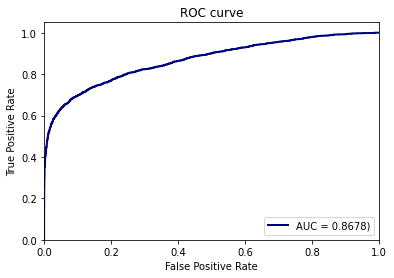

In [24]:
plt.figure()
plt.step(fpr, tpr,color='navy',linewidth=2,label='AUC = {0:.4f})'.format(testauc))
#plt.plot([0, 0], [1, 1], color='navy',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc=4)
plt.savefig("auc_curve.jpg")

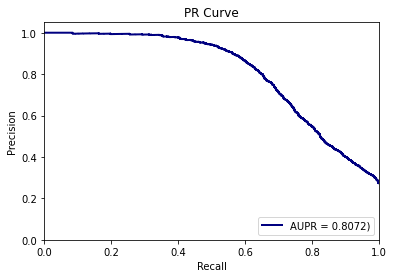

In [25]:
plt.figure()
plt.step(recall,precision,color='navy',linewidth=2,label='AUPR = {0:.4f})'.format(testaupr))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR Curve')
plt.legend(loc=4)
plt.savefig("pr_curve.jpg")

In [26]:
#/home/liupei89/shfolder/new/TransCNN/3/data10_0.35_0.0001_500
#/home/liupei89/shfolder/new/TransCNN/4/data10_0.25_500
#/home/liupei89/shfolder/new/TransCNN/1
with open('/home/liupei89/shfolder/new/TransCNN/13/modelResult.pkl','rb') as f:  # Python 3: open(..., 'rb')
        trainloss, trainauc,trainaupr,valloss,valauc,valaupr,lrchange = pickle.load(f)

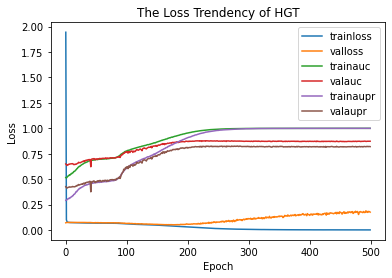

In [27]:
#plt.plot(trainloss)
plt.figure()
plt.plot(trainloss,label='trainloss')
plt.plot(valloss,label='valloss')
plt.plot(trainauc,label='trainauc')
plt.plot(valauc,label='valauc')
plt.plot(trainaupr,label='trainaupr')
plt.plot(valaupr,label='valaupr')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('The Loss Trendency of HGT')
plt.legend(loc=1)

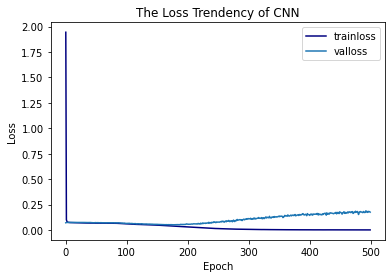

In [28]:
#plt.plot(trainloss)
plt.figure()
plt.plot(trainloss,label='trainloss',color='navy')
plt.plot(valloss,label='valloss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('The Loss Trendency of CNN')
plt.legend(loc=1)

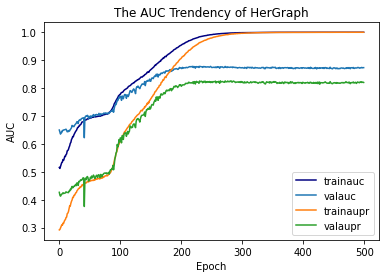

In [29]:
#plt.plot(trainloss)
plt.figure()
plt.plot(trainauc,label='trainauc',color='navy')
plt.plot(valauc,label='valauc')
plt.plot(trainaupr,label='trainaupr')
plt.plot(valaupr,label='valaupr')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('The AUC Trendency of HerGraph')
plt.legend(loc=4)

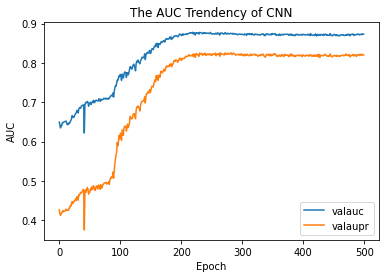

In [30]:
#plt.plot(trainloss)
plt.figure()
# plt.plot(trainauc,label='trainauc',color='navy')
plt.plot(valauc,label='valauc')
# plt.plot(trainaupr,label='trainaupr')
plt.plot(valaupr,label='valaupr')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('The AUC Trendency of CNN')
plt.legend(loc=4)

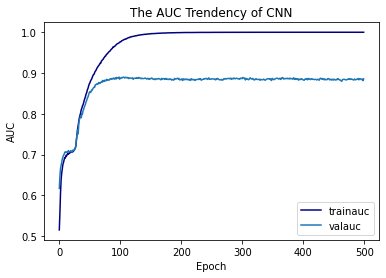

In [55]:
plt.figure()
plt.plot(trainauc,label='trainauc',color='navy')
plt.plot(valauc,label='valauc')
plt.xlabel('Epoch')
plt.ylabel('AUC')
#plt.ylim([0.7, 0.9])
#plt.xlim([0.0, 1.0])
plt.title('The AUC Trendency of CNN')
plt.legend(loc=4)

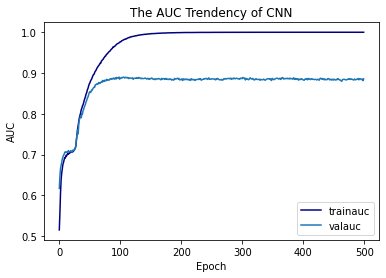

In [56]:
plt.figure()
plt.plot(trainauc,label='trainauc',color='navy')
plt.plot(valauc,label='valauc')
plt.xlabel('Epoch')
plt.ylabel('AUC')
#plt.ylim([0.7, 0.9])
#plt.xlim([0.0, 1.0])
plt.title('The AUC Trendency of CNN')
plt.legend(loc=4)

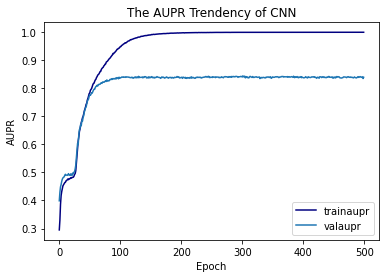

In [57]:
plt.figure()
plt.plot(trainaupr,label='trainaupr',color='navy')
plt.plot(valaupr,label='valaupr')
plt.xlabel('Epoch')
plt.ylabel('AUPR')
plt.title('The AUPR Trendency of CNN')
plt.legend(loc=4)

In [32]:
i=0
for name,parameters in CNN.named_parameters():
    print(i,name,':',parameters.size())
    i=i+1

0 mcnn.stem.0.1.weight : torch.Size([128, 4, 3])
1 mcnn.stem.0.1.bias : torch.Size([128])
2 mcnn.stem.1.fn.0.weight : torch.Size([128])
3 mcnn.stem.1.fn.0.bias : torch.Size([128])
4 mcnn.stem.1.fn.2.1.weight : torch.Size([128, 128, 3])
5 mcnn.stem.1.fn.2.1.bias : torch.Size([128])
6 mcnn.transformer_encoder.layers.0.self_attn.in_proj_weight : torch.Size([384, 128])
7 mcnn.transformer_encoder.layers.0.self_attn.in_proj_bias : torch.Size([384])
8 mcnn.transformer_encoder.layers.0.self_attn.out_proj.weight : torch.Size([128, 128])
9 mcnn.transformer_encoder.layers.0.self_attn.out_proj.bias : torch.Size([128])
10 mcnn.transformer_encoder.layers.0.linear1.weight : torch.Size([256, 128])
11 mcnn.transformer_encoder.layers.0.linear1.bias : torch.Size([256])
12 mcnn.transformer_encoder.layers.0.linear2.weight : torch.Size([128, 256])
13 mcnn.transformer_encoder.layers.0.linear2.bias : torch.Size([128])
14 mcnn.transformer_encoder.layers.0.norm1.weight : torch.Size([128])
15 mcnn.transformer_en

In [60]:
CNN.state_dict()

OrderedDict([('mcnn.stem.0.1.weight',
              tensor([[[-0.1189,  0.2361, -0.0791,  ..., -0.0085,  0.2822,  0.2337],
                       [-0.2489,  0.6844, -0.4770,  ...,  0.0218,  0.0034, -0.5197],
                       [-0.1611,  0.0042, -0.0389,  ..., -0.0096,  0.2206, -0.5511],
                       [ 0.5814, -0.0426,  0.2121,  ...,  0.0198, -0.2765,  0.0087]],
              
                      [[-0.0464,  0.1006,  0.0744,  ...,  0.0736,  0.5061,  0.2956],
                       [-0.0635,  0.1445,  0.0645,  ...,  0.0265, -0.0695, -0.1983],
                       [ 0.0625, -0.2430, -0.1389,  ..., -0.2397, -0.0152,  0.1343],
                       [ 0.0675, -0.1459, -0.2392,  ...,  0.3172,  0.0259, -0.0976]],
              
                      [[ 0.1481, -0.1801, -0.0373,  ..., -0.1918,  0.4965,  0.0567],
                       [ 0.3309, -0.3841, -0.3090,  ..., -0.0598, -0.1007,  0.4887],
                       [ 0.1457, -0.2033,  0.0363,  ...,  0.2817,  0.2421, -0.00

In [61]:
torch.save(CNN.state_dict(),'transCNN3.pth')

In [66]:
train_data['miRNA'].seq.size()

torch.Size([279, 25, 4])

In [63]:
CNN.mcnn.cpu()
#CNN.gcnn.cpu()

mCNN(
  (stem): Sequential(
    (0): Sequential(
      (0): ConstantPad1d(padding=(3, 3), value=0)
      (1): Conv1d(4, 128, kernel_size=(7,), stride=(1,))
    )
    (1): Residual(
      (fn): Sequential(
        (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): GELU()
        (2): Sequential(
          (0): ConstantPad1d(padding=(3, 3), value=0)
          (1): Conv1d(128, 128, kernel_size=(7,), stride=(1,))
        )
      )
    )
  )
  (position): PositionalEncoding(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=256, out_fe

In [67]:
CNN.mcnn.eval()
#CNN.gcnn.eval()
with torch.no_grad():
    xm = CNN.mcnn(train_data['miRNA'].seq)
    #X2 = CNN.gcnn(Xg)

In [69]:
xm.size()

torch.Size([279, 1024])

In [70]:
CNN.gcnn.cpu()

gCNN(
  (stem1): Sequential(
    (0): Conv2_Layer(
      (conv1): Sequential(
        (0): Conv2d(15, 7, kernel_size=(7, 1), stride=(1, 1))
      )
      (norm1): BatchNorm2d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (eca2): eca_layer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (conv): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (sigmoid): Sigmoid()
      )
      (conv2): Sequential(
        (0): Conv2d(7, 1, kernel_size=(7, 1), stride=(1, 1))
      )
      (norm2): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (eca3): eca_layer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (conv): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (sigmoid): Sigmoid()
      )
      (relu): GELU()
    )
    (1): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (stem2): Sequential(
    (0): Sequentia

In [71]:
CNN.gcnn.eval()
#CNN.gcnn.eval()
with torch.no_grad():
    xg = CNN.gcnn(train_data['gene'].seq)
    #X2 = CNN.gcnn(Xg)

In [72]:
xg

tensor([[-7.3445e-05, -5.2925e-02, -1.3125e-01,  ..., -1.2496e-01,
          0.0000e+00, -1.4375e-02],
        [-1.0005e-01, -1.5469e-01, -7.2962e-02,  ..., -5.9493e-03,
          2.7088e-01, -1.8373e-02],
        [-1.0878e-01, -2.0379e-04,  1.9757e+00,  ...,  2.4746e-01,
          1.5385e+00, -8.9531e-03],
        ...,
        [-1.8354e-02, -1.7024e-03,  6.7827e-02,  ...,  5.5651e-01,
          1.4085e+00, -7.1644e-03],
        [-5.6246e-06,  1.3329e+00, -4.1372e-04,  ..., -1.0312e-02,
         -1.6865e-01,  0.0000e+00],
        [-4.6579e-07,  5.6819e-01, -1.1128e-03,  ...,  6.7938e-01,
         -3.5654e-03, -4.0845e-03]])

In [73]:
xg.size()

torch.Size([14676, 1024])

In [74]:
with open('TranCNN3_mgEmbedding.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([xm,xg], f)

In [77]:
train_data['miRNA'].x

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [78]:
train_data['miRNA'].mm

tensor([[0., 1., 1.,  ..., 1., 0., 0.],
        [1., 0., 1.,  ..., 1., 0., 0.],
        [1., 1., 0.,  ..., 1., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

In [79]:
train_data['miRNA'].sim

tensor([[1., 1., 1.,  ..., 1., 0., 0.],
        [1., 1., 1.,  ..., 1., 0., 0.],
        [1., 1., 1.,  ..., 1., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 1., 1.]])

In [12]:
with open('/lustre06/project/6050659/liupei89/Testcell/newNetData/pos_neg/newdataCombine00.pkl','rb') as f:  # Python 3: open(..., 'rb')
        train_data,val_data,test_data,m,g = pickle.load(f)

In [13]:
xm1=X1
xg1=X2

In [14]:
train_data['miRNA'].x=xm1
train_data['gene'].x=xg1
val_data['miRNA'].x=xm1
val_data['gene'].x=xg1
test_data['miRNA'].x=xm1
test_data['gene'].x=xg1

In [15]:
with open('/lustre06/project/6050659/liupei89/Testcell/newNetData/pos_neg/newdataCombine00_pre.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([train_data,val_data,test_data,m,g], f)

In [16]:
train_data

HeteroData(
  miRNA={
    x=[279, 1024],
    seq=[279, 25, 4]
  },
  gene={
    x=[14676, 1024],
    seq=[14676, 15, 2500, 4]
  },
  (miRNA, regulate, gene)={
    edge_index=[2, 129775],
    edge_label_index=[2, 129775],
    edge_label=[129775]
  },
  (gene, coocurrence, gene)={ edge_index=[2, 2087674] },
  (gene, rev_regulate, miRNA)={ edge_index=[2, 129775] }
)

In [23]:
mcnn=nn.Sequential(*list(CNN.mcnn.children())[:-1])